In [1]:
## imports
import sys
import os
import numpy as np
import xarray as xr
import cmocean
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import eofs
from eofs.xarray import Eof
import cftime
import nc_time_axis

import mtspec

# from pylab import *

import datetime
import time
import glob, os
import math
import matplotlib.colors as colors
import xesmf as xe
from defs import lon180, salmask, latweights, makedz

In [2]:
datafolder = ''

In [3]:
experiment = 'E280' 
model = 'COSMOS'
folder = datafolder+'Raw_data/'+model+'/'

In [4]:
if experiment == 'E280':
    dsV = xr.open_dataset(folder+experiment+'/COSMOS_E280.vo_2650-2749_annual_climatology_remapcon_1x1deg.nc')
    dsS = xr.open_dataset(folder+experiment+'/COSMOS_E280.sao_2650-2749_annual_climatology_remapcon_1x1deg.nc')
    dsr = xr.open_dataset(folder+experiment+'/BEK_PI_360x180.nc')
elif experiment == 'Eoi400':
    dsV = xr.open_dataset(folder+experiment+'/COSMOS_Eoi400.vo_2650-2749_annual_climatology_remapcon_1x1deg.nc')
    dsS = xr.open_dataset(folder+experiment+'/COSMOS_Eoi400.sao_2650-2749_annual_climatology_remapcon_1x1deg.nc')
    dsr = xr.open_dataset(folder+experiment+'/BEK_Plio_360x180.nc')

## Separation MOC and gyre OHT Atlantic

In [5]:
vvel = dsV.vo[0]*100 #vvel in cm/s
salt = dsS.so[0] #salinity in psu

#Atlantic Ocean region
region = dsr.THO[0,0]

In [6]:
ds = dsS.copy(deep=True)

#1-D array with spacing of depth grid
dz = np.zeros(len(ds.lev))
dz[0] = ds.lev[0].values*2
depth = dz[0]
for i in range(1,len(ds.lev)):
    dz[i] = (ds.lev[i].values-depth)*2
    depth = depth+dz[i]
dz = dz*100 #Depth spacing. Units: cm
ds['dz'] = xr.DataArray(data=dz, dims=("lev"))
dz = ds.dz

#2-D array with spacing of horizontal UV grid
r = 6.37122e8 #radius Earth in cm
dlon = np.deg2rad((ds.lon[2]-ds.lon[1]))*r*np.cos(np.deg2rad(ds.lat)) #Lon spacing. Units: cm

a = dlon
dlon = np.zeros([len(ds.lat),len(ds.lon)])
for i in range(len(ds.lon)):
    dlon[:,i]=a.values
ds['dlon']=xr.DataArray(data = dlon, dims=("lat","lon"))
dlon = ds.dlon

In [7]:
#Define reference salinity S0 as average Atlantic salinity
folder2 = datafolder+'Processed/'
dssal = xr.open_dataset(folder2+model+'/'+experiment+'/so_1x1_100yr.nc')
dssal = lon180(dssal)

S0 = dssal.so.where(salmask()>-1).weighted(makedz(dssal)).mean(dim='z').weighted(latweights()).mean()

In [8]:
SALT = salt.where(region>0).where(region<6)  #  g/kg 
VVEL = vvel.where(region>0).where(region<6) #cm/s

In [9]:
#zonal mean components
VVEL_zm = VVEL.mean(dim='lon')
SALT_zm = SALT.mean(dim='lon')

SALT_zm_3D = SALT/SALT
SALT_zm_3D = SALT_zm_3D*SALT_zm

VVEL_zm_3D = VVEL/VVEL
VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

#azonal components 
SALT_prime = (SALT - SALT_zm) # azonal salt component (x,y,z) 
VVEL_prime = (VVEL - VVEL_zm)  # azonal velocity comp. (x,y,z) 

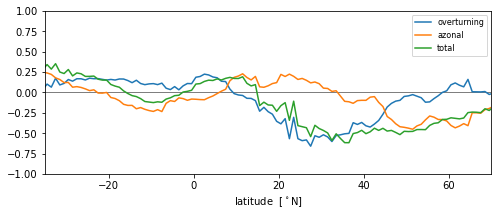

In [10]:
#Integrate to obtain transports
Fov = (-1/S0*(VVEL_zm_3D*(SALT_zm_3D-S0)*dlon*dz).sum(dim=['lon','lev']))/1e12
Faz = (-1/S0*(VVEL_prime*SALT_prime*dlon*dz).sum(dim=['lon','lev']))/1e12 
Ftotal = (-1/S0*(VVEL*(SALT-S0)*dlon*dz).sum(dim=['lon','lev']))/1e12

plt.figure(figsize=(8,3))
plt.axhline(0,c='k',lw=.5)
plt.plot(dsV.lat, Fov, label='overturning')
plt.plot(dsV.lat, Faz, label='azonal')
plt.plot(dsV.lat, Ftotal, label='total')
#plt.plot(dsV.lat, Fov+Faz, label='ov+az')

plt.xlim([-35,70])
plt.ylim([-1,1])
plt.xlabel(r'latitude  [$^\circ$N]')
plt.legend(fontsize=8)

In [11]:
dsE = xr.Dataset(data_vars = dict(Fov=(["lat"], Fov), Faz=(["lat"], Faz), Ftot=(["lat"], Ftotal)), coords = dict(lat = dsV.lat.values))    
xr.Dataset.to_netcdf(dsE, path = datafolder+'Processed/'+model+'/'+experiment+'/decomFW_100yr.nc')

## FW Labrador

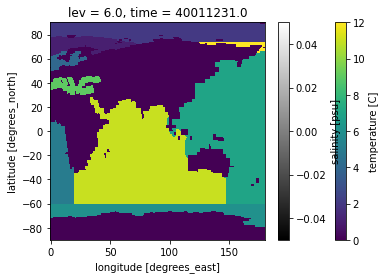

In [14]:
dsS = lon180(dsS)
dsV = lon180(dsV)
region = lon180(region)

ds = dsS.copy(deep=True)

#compute new spacing arrays to put on -180-180 grid

#1-D array with spacing of depth grid
dz = np.zeros(len(ds.lev))
dz[0] = ds.lev[0].values*2
depth = dz[0]
for i in range(1,len(ds.lev)):
    dz[i] = (ds.lev[i].values-depth)*2
    depth = depth+dz[i]
dz = dz*100 #Depth spacing. Units: cm
ds['dz'] = xr.DataArray(data=dz, dims=("lev"))
dz = ds.dz

#2-D array with spacing of horizontal UV grid
r = 6.37122e8 #radius Earth in cm
dlon = np.deg2rad((ds.lon[2]-ds.lon[1]))*r*np.cos(np.deg2rad(ds.lat)) #Lon spacing. Units: cm

a = dlon
dlon = np.zeros([len(ds.lat),len(ds.lon)])
for i in range(len(ds.lon)):
    dlon[:,i]=a.values
ds['dlon']=xr.DataArray(data = dlon, dims=("lat","lon"))
dlon = ds.dlon

#visualize region
region.plot()
salt[0].where(region>0).where(region<6).where(dsS.lat>=50).where(dsS.lat<74).where(dsS.lon<-45).where(dsS.lon>-70).plot(cmap='gray')

salt = dsS.so[0] #salinity in psu
vvel = dsV.vo[0]*100 #vvel in cm/s

In [15]:
SALT = salt.where(region>0).where(region<6).where(dsS.lat>=50).where(dsS.lat<74).where(dsS.lon<-45).where(dsS.lon>-70) #  g/kg 
VVEL = vvel.where(region>0).where(region<6).where(dsS.lat>=50).where(dsS.lat<74).where(dsS.lon<-45).where(dsS.lon>-70)

#zonal mean components
VVEL_zm = VVEL.mean(dim='lon')
SALT_zm = SALT.mean(dim='lon')

SALT_zm_3D = SALT/SALT
SALT_zm_3D = SALT_zm_3D*SALT_zm

VVEL_zm_3D = VVEL/VVEL
VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

#azonal components on u grid
SALT_prime = (SALT - SALT_zm) # azonal salt component (x,y,z) [g/kg]
VVEL_prime = (VVEL - VVEL_zm)  # azonal velocity comp. (x,y,z) [cm/s]

#integrate to compute transports
Fov = (-1/S0*(VVEL_zm_3D*(SALT_zm_3D-S0)*dlon*dz).sum(dim=['lon','lev']))/1e12
Faz = (-1/S0*(VVEL_prime*SALT_prime*dlon*dz).sum(dim=['lon','lev']))/1e12 
Ftotal = (-1/S0*(VVEL*(SALT-S0)*dlon*dz).sum(dim=['lon','lev']))/1e12

dsE = xr.Dataset(data_vars = dict(Fov=(["lat"], Fov[145:164]), Faz=(["lat"], Faz[145:164]), Ftot=(["lat"], Ftotal[145:164])), coords = dict(lat = dsV.lat[145:164].values))    
xr.Dataset.to_netcdf(dsE, path = datafolder+'Processed/'+model+'/'+experiment+'/decomFW_Lab_100yr.nc')

## FW Fram Strait

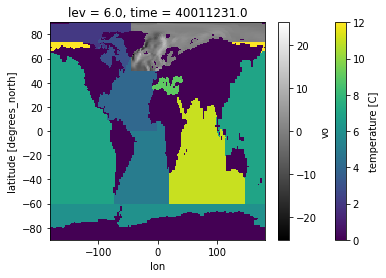

In [16]:
#visualize region
region.plot()
vvel[0].where(region>0).where(region<6).where(dsS.lat>=50).where(dsS.lon>=-45).plot(cmap='gray')

In [17]:
SALT = salt.where(region>0).where(region<6).where(dsS.lat>=50).where(dsS.lon>=-45) #  g/kg 
VVEL = vvel.where(region>0).where(region<6).where(dsS.lat>=50).where(dsS.lon>=-45)

#zonal mean components 
VVEL_zm = VVEL.mean(dim='lon')
SALT_zm = SALT.mean(dim='lon')

SALT_zm_3D = SALT/SALT
SALT_zm_3D = SALT_zm_3D*SALT_zm

VVEL_zm_3D = VVEL/VVEL
VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

#azonal components 
SALT_prime = (SALT - SALT_zm) # azonal salt component (x,y,z) [g/kg]
VVEL_prime = (VVEL - VVEL_zm)  # azonal velocity comp. (x,y,z) [cm/s]

#Integrate to compute transports
Fov = (-1/S0*(VVEL_zm_3D*(SALT_zm_3D-S0)*dlon*dz).sum(dim=['lon','lev']))/1e12
Faz = (-1/S0*(VVEL_prime*SALT_prime*dlon*dz).sum(dim=['lon','lev']))/1e12 
Ftotal = (-1/S0*(VVEL*(SALT-S0)*dlon*dz).sum(dim=['lon','lev']))/1e12

dsE = xr.Dataset(data_vars = dict(Fov=(["lat"], Fov[145:164]), Faz=(["lat"], Faz[145:164]), Ftot=(["lat"], Ftotal[145:164])), coords = dict(lat = dsV.lat[145:164].values))    
xr.Dataset.to_netcdf(dsE, path = datafolder+'Processed/'+model+'/'+experiment+'/decomFW_Fram_100yr.nc')

## FW Bering Strait

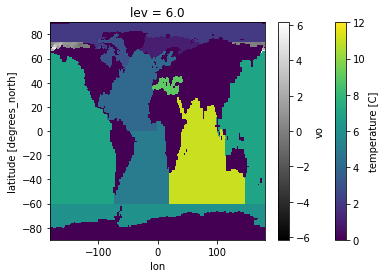

In [18]:
#visualize region
region.plot()
vvel[0].where(region==12).plot(cmap='gray')

In [19]:
if experiment == 'E280':
    SALT = salt.where(region==12) #  g/kg 
    VVEL = vvel.where(region==12)

    #zonal mean components 
    VVEL_zm = VVEL.mean(dim='lon')
    SALT_zm = SALT.mean(dim='lon')

    SALT_zm_3D = SALT/SALT
    SALT_zm_3D = SALT_zm_3D*SALT_zm

    VVEL_zm_3D = VVEL/VVEL
    VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

    #azonal components
    SALT_prime = (SALT - SALT_zm) # azonal salt component (x,y,z) [g/kg]
    VVEL_prime = (VVEL - VVEL_zm)  # azonal velocity comp. (x,y,z) [cm/s]

    #integrate to obtain transports
    Fov = (-1/S0*(VVEL_zm_3D*(SALT_zm_3D-S0)*dlon*dz).sum(dim=['lon','lev']))/1e12
    Faz = (-1/S0*(VVEL_prime*SALT_prime*dlon*dz).sum(dim=['lon','lev']))/1e12 
    Ftotal = (-1/S0*(VVEL*(SALT-S0)*dlon*dz).sum(dim=['lon','lev']))/1e12

    dsE = xr.Dataset(data_vars = dict(Fov=(["lat"], Fov[150:165]), Faz=(["lat"], Faz[150:165]), Ftot=(["lat"], Ftotal[150:165])), coords = dict(lat = dsV.lat[150:165].values))    
    xr.Dataset.to_netcdf(dsE, path = datafolder+'Processed/'+model+'/'+experiment+'/decomFW_BS_100yr.nc')